In [10]:
import pandas as pd
import optuna
import numpy as np
from pycaret.datasets import get_data
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn. preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import warnings

In [3]:
warnings.filterwarnings('ignore')
train = pd.read_csv(r'D:\Python\Git_Github\Repositorios\Kagle\Kagle\Treino_Tratado.csv')

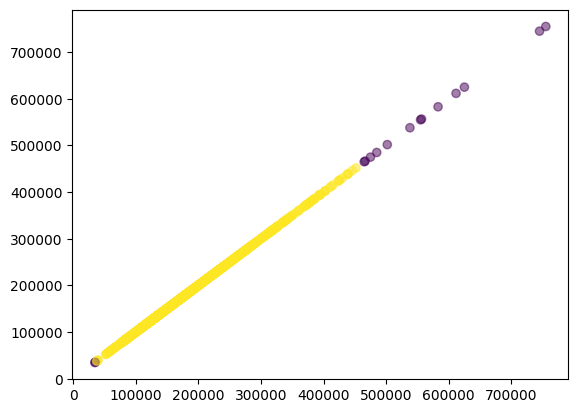

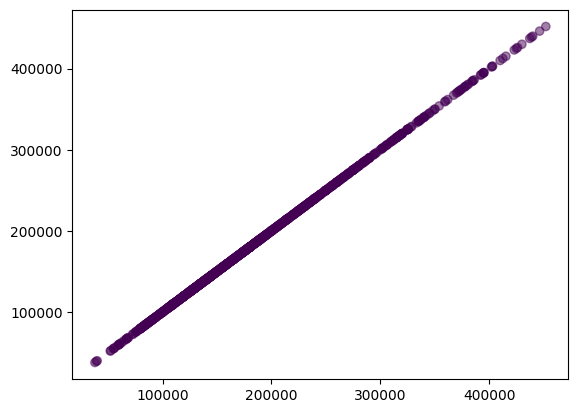

In [4]:
anom = IsolationForest(contamination=0.01, random_state=42)
anom.fit(train['SalePrice'].to_frame())

prediction_anomaly = anom.predict(train['SalePrice'].to_frame())

train['Anomaly'] = prediction_anomaly

plt.scatter(train['SalePrice'],train['SalePrice'],c=prediction_anomaly,cmap='viridis',alpha=0.5)
plt.show()

train = train.loc[train['Anomaly'] == 1]

plt.scatter(train['SalePrice'],train['SalePrice'],c=train['Anomaly'],cmap='viridis',alpha=0.5)
plt.show()

train = train.drop('Anomaly', axis=1)

In [5]:
remover = train.columns[(train.isna().sum()/train.shape[0]) > 0.1]
train = train.drop(remover, axis=1)
colunas_objeto = train.select_dtypes(include='object')
colunas_mais_de_9_valores = colunas_objeto.columns[colunas_objeto.nunique() > 9]
train = train.drop(colunas_mais_de_9_valores, axis=1)
train = train.fillna(method='ffill')

train_columns = list(train.drop('SalePrice',axis=1).columns)
#train.select_dtypes(include='object').nunique().sort_values(ascending=False)

In [6]:
objeto = train.select_dtypes(include='object')
num = train.drop('SalePrice',axis=1).select_dtypes(exclude='object')

In [7]:
onehot = OneHotEncoder(sparse=False)
minmax = MinMaxScaler()

In [11]:
X_minmax = minmax.fit_transform(num)
X_onehot = onehot.fit_transform(objeto)
X = np.append(X_minmax, X_onehot, axis=1)
y = train['SalePrice']

print(X.shape)
print(y.shape)

(1445, 215)
(1445,)


In [13]:
pca = PCA(n_components=80, random_state=42)
X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

def testar(folds):
    n_estimators = folds.suggest_int('n_estimators', 50,600)
    max_depth = folds.suggest_int('max_depth', 1,15)

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=n_estimators, max_depth=max_depth)
    score = -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=9).mean()

    return score

study = optuna.create_study(direction='minimize')
study.optimize(testar, n_trials=50)

best_params = study.best_params
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)

model.fit(X_train, y_train)
print(np.sqrt(mean_squared_error(y_train, model.predict(X_train))))


[I 2024-02-02 15:35:27,454] A new study created in memory with name: no-name-0aa7cbf6-cb19-45b5-bc7f-47dcb3a91293


[I 2024-02-02 15:35:29,836] Trial 0 finished with value: 1256300603.371 and parameters: {'n_estimators': 504, 'max_depth': 2}. Best is trial 0 with value: 1256300603.371.
[I 2024-02-02 15:35:36,368] Trial 1 finished with value: 1418372087.2100878 and parameters: {'n_estimators': 273, 'max_depth': 6}. Best is trial 0 with value: 1256300603.371.
[I 2024-02-02 15:35:38,635] Trial 2 finished with value: 1307469761.5334747 and parameters: {'n_estimators': 352, 'max_depth': 4}. Best is trial 0 with value: 1256300603.371.
[I 2024-02-02 15:35:46,734] Trial 3 finished with value: 1418372177.9419534 and parameters: {'n_estimators': 412, 'max_depth': 6}. Best is trial 0 with value: 1256300603.371.
[I 2024-02-02 15:35:46,893] Trial 4 finished with value: 1310715384.317557 and parameters: {'n_estimators': 64, 'max_depth': 2}. Best is trial 0 with value: 1256300603.371.
[I 2024-02-02 15:35:53,619] Trial 5 finished with value: 1348836538.9869773 and parameters: {'n_estimators': 600, 'max_depth': 5}. 

21115.369958681036


In [14]:
teste = pd.read_csv(r'D:\Python\Git_Github\Repositorios\Kagle\Kagle\Teste_Tratado.csv')

df_teste = pd.DataFrame(teste)

df_teste = df_teste[train_columns]

objeto_teste = df_teste.select_dtypes(include='object')
num_teste = df_teste.select_dtypes(exclude='object')

objeto_teste = objeto_teste.fillna(method='ffill')
num_teste = num_teste.fillna(method='ffill')

X_minmax = minmax.transform(num_teste)
X_onehot = onehot.transform(objeto_teste)
X_teste = np.append(X_minmax, X_onehot, axis=1)

Predict_teste = model.predict(X_teste)

KeyError: "['Anomaly'] not in index"

In [11]:
df_teste['SalePrice'] = Predict_teste

kagle = df_teste[['Id', 'SalePrice']]
kagle.to_csv(r'D:\Python\Git_Github\Repositorios\Kagle\Kagle\kagle_house_v13.csv',index=False)